In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from numba import jit
import time
import gc

In [2]:
# Compute gini

# from CPMP's kernel https://www.kaggle.com/cpmpml/extremely-fast-gini-computation
@jit
def eval_gini(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    ntrue = 0
    gini = 0
    delta = 0
    n = len(y_true)
    for i in range(n-1, -1, -1):
        y_i = y_true[i]
        ntrue += y_i
        gini += y_i * delta
        delta += 1 - y_i
    gini = 1 - 2 * gini / np.float(ntrue * (n - ntrue))
    return gini

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = -eval_gini(labels, preds)
    return [('gini', gini_score)]

In [7]:
train_meta = pd.DataFrame()
test_meta = pd.DataFrame()

fold = "Data/meta1/"
columns = ["lr", "lreg", "lda", "knn", "nb", "rf", "ad", "gb", "xgb1", "xgb2", "xgb3", "xgb4"]
for col in columns:
    name = "y_train_" + col + ".out"
    print name
    train_meta[col] = np.loadtxt(fold+name)
    name = "y_test_" + col + ".out"
#    test_meta[col] = np.loadtxt(fold+name)

y_train_lr.out
y_train_lreg.out
y_train_lda.out
y_train_knn.out
y_train_nb.out
y_train_rf.out
y_train_ad.out
y_train_gb.out
y_train_xgb1.out
y_train_xgb2.out
y_train_xgb3.out
y_train_xgb4.out


In [8]:
# Read data
train_df = pd.read_csv('Data/train.csv', na_values="-1") # .iloc[0:200,:]
#test_df = pd.read_csv('Data/test.csv', na_values="-1")

In [9]:
train_meta["y"] = train_df.target

In [10]:
for col in train_meta.columns:
    print col, eval_gini(train_meta["y"], train_meta[col])

lr 0.261480444372
lreg 0.261289266811
lda 0.261481382332
knn 0.172214469131
nb 0.236574751459
rf 0.26888755436
ad 0.271640830902
gb 0.282853370441
xgb1 0.287997209454
xgb2 0.28460125291
xgb3 0.248615122473
xgb4 0.288576782051
y 1.0


In [26]:
yy1 =  0.5*train_meta["xgb1"] + 0.5*train_meta["xgb4"] 
print eval_gini(train_meta["y"], yy1)

0.289436475541


In [21]:
yy2 =  0.4*train_meta["xgb2"] + 0.6*train_meta["gb"] 
print eval_gini(train_meta["y"], yy2)

0.285001680513


In [22]:
yy = 0.5*yy1 + 0.5*yy2
print eval_gini(train_meta["y"], yy)

0.285909338063


In [64]:
name = "y_train_" + "xgb5" + ".out"
print name
train_meta[col] = np.loadtxt(fold+"y_train_xgb4.out")

y_train_xgb5.out


In [43]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))


def target_encode(trn_series=None,    # Revised to encode validation series
                  val_series=None,
                  tst_series=None,
                  target=None,
                  min_samples_leaf=1,
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior
    """
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index
    ft_val_series = pd.merge(
        val_series.to_frame(val_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=val_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_val_series.index = val_series.index
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_val_series, noise_level), add_noise(ft_tst_series, noise_level)

In [68]:
train_meta = pd.DataFrame()
test_meta = pd.DataFrame()

fold = "/home/amin/Desktop/Porto/Data/meta1/"
columns = ["lr", "lreg", "lda", "knn", "nb", "rf", "ad", "gb",  "xgb2", "xgb3", "xgb4"]
for col in columns:
    name = "y_train_" + col + ".out"
    print name
    train_meta[col] = np.loadtxt(fold+name)
    name = "y_test_" + col + ".out"
    test_meta[col] = np.loadtxt(fold+name)

y_train_lr.out
y_train_lreg.out
y_train_lda.out
y_train_knn.out
y_train_nb.out
y_train_rf.out
y_train_ad.out
y_train_gb.out
y_train_xgb2.out
y_train_xgb3.out
y_train_xgb4.out


In [27]:
# Read data
train_df = pd.read_csv('Data/train.csv', na_values="-1") # .iloc[0:200,:]
test_df = pd.read_csv('Data/test.csv', na_values="-1")

In [33]:
# from olivier
train_features = [
    "ps_car_13",  #            : 1571.65 / shadow  609.23
	"ps_reg_03",  #            : 1408.42 / shadow  511.15
	"ps_ind_05_cat",  #        : 1387.87 / shadow   84.72
	"ps_ind_03",  #            : 1219.47 / shadow  230.55
	"ps_ind_15",  #            :  922.18 / shadow  242.00
	"ps_reg_02",  #            :  920.65 / shadow  267.50
	"ps_car_14",  #            :  798.48 / shadow  549.58
	"ps_car_12",  #            :  731.93 / shadow  293.62
	"ps_car_01_cat",  #        :  698.07 / shadow  178.72
	"ps_car_07_cat",  #        :  694.53 / shadow   36.35
	"ps_ind_17_bin",  #        :  620.77 / shadow   23.15
	"ps_car_03_cat",  #        :  611.73 / shadow   50.67
	"ps_reg_01",  #            :  598.60 / shadow  178.57
	"ps_car_15",  #            :  593.35 / shadow  226.43
	"ps_ind_01",  #            :  547.32 / shadow  154.58
	"ps_ind_16_bin",  #        :  475.37 / shadow   34.17
	"ps_ind_07_bin",  #        :  435.28 / shadow   28.92
	"ps_car_06_cat",  #        :  398.02 / shadow  212.43
	"ps_car_04_cat",  #        :  376.87 / shadow   76.98
	"ps_ind_06_bin",  #        :  370.97 / shadow   36.13
	"ps_car_09_cat",  #        :  214.12 / shadow   81.38
	"ps_car_02_cat",  #        :  203.03 / shadow   26.67
	"ps_ind_02_cat",  #        :  189.47 / shadow   65.68
	"ps_car_11",  #            :  173.28 / shadow   76.45
	"ps_car_05_cat",  #        :  172.75 / shadow   62.92
	"ps_calc_09",  #           :  169.13 / shadow  129.72
	"ps_calc_05",  #           :  148.83 / shadow  120.68
	"ps_ind_08_bin",  #        :  140.73 / shadow   27.63
	"ps_car_08_cat",  #        :  120.87 / shadow   28.82
	"ps_ind_09_bin",  #        :  113.92 / shadow   27.05
	"ps_ind_04_cat",  #        :  107.27 / shadow   37.43
	"ps_ind_18_bin",  #        :   77.42 / shadow   25.97
	"ps_ind_12_bin",  #        :   39.67 / shadow   15.52
	"ps_ind_14",  #            :   37.37 / shadow   16.65
]
# add combinations
combs = [
    ('ps_reg_01', 'ps_car_02_cat'),  
    ('ps_reg_01', 'ps_car_04_cat'),
]

In [34]:
target = train_df["target"]
ntrain = train_df.shape[0]
data = pd.concat([train_df[train_features], test_df[train_features]], axis=0, ignore_index=True)
print data.shape
#del train_df, test_df
#gc.collect()

(1488028, 34)


In [35]:
# replace missing values with median
columns = ["ps_reg_03", "ps_car_11", "ps_car_12", "ps_car_14"]
data[columns] = data[columns].replace(-1, np.NaN)
for col in columns:
    med = data.loc[:ntrain-1, col].dropna().median()
    data.loc[data[col].isnull(), col] = med
    print med

0.8015609771
3.0
0.3741657387
0.3734969879


In [36]:
from sklearn.preprocessing import LabelEncoder
columns = [f for f in data.columns if "_cat" in f]

for col in columns:
    data.loc[data[col].isnull(), col] = -1
    enc = LabelEncoder()
    data[col] = enc.fit_transform(data[col])

In [37]:
threshol = 500
columns = [f for f in data.columns if "_cat" in f]

for col in columns:
    temp = data.loc[:ntrain-1, col]
    density = temp.value_counts().sort_values()
    count = density.iloc[0]
    while count < threshol:
        ix0 = density.index[0]; ix1 = density.index[1]
        data.loc[data[col] == ix0, col] = ix1

        temp = data.loc[:ntrain-1, col]
        density = temp.value_counts().sort_values()
        count = density.iloc[0]

In [38]:
# Process data
start = time.time()
for n_c, (f1, f2) in enumerate(combs):
    name1 = f1 + "_plus_" + f2
    print('current feature %60s %4d in %5.1f', (name1, n_c + 1, (time.time() - start) / 60))

    data[name1] = data[f1].apply(lambda x: str(x)) + "_" + data[f2].apply(lambda x: str(x))
    # Label Encode
    lbl = LabelEncoder()
    lbl.fit(list(data[name1].values))
    data[name1] = lbl.transform(list(data[name1].values))

('current feature %60s %4d in %5.1f', ('ps_reg_01_plus_ps_car_02_cat', 1, 1.6399224599202474e-05))
('current feature %60s %4d in %5.1f', ('ps_reg_01_plus_ps_car_04_cat', 2, 0.04063146511713664))


In [39]:
from sklearn.preprocessing import MinMaxScaler
columns = [f for f in data.columns if "_bin" not in f and "_cat" not in f]

min_max_scaler = MinMaxScaler()
data[columns] = min_max_scaler.fit_transform(list(data[columns].values))

In [62]:
X = pd.concat([data.loc[:ntrain-1, :], train_meta], axis=1)
test = pd.concat([data.loc[ntrain:, :], test_meta], axis=1)
print X.shape, test.shape

f_cats = [f for f in X.columns if "_cat" in f]

(595212, 48) (1488028, 48)


In [71]:
import xgboost as xgb
params = {
          'objective': 'binary:logistic',  
          'max_depth': 4, 
          'learning_rate': 0.1,
          'subsample': 0.8,  
          'min_child_weight': 0.77, 
          'colsample_bytree': 0.9,
#           'scale_pos_weight': 1.6,
#           'gamma': 10,  
#           'reg_alpha': 8,
#           'reg_lambda': 1.3
         }

In [72]:
y_valid_pred = 0*target
y_test_pred = 0

# Set up folds
from sklearn.model_selection import StratifiedKFold
K = 10
skf = StratifiedKFold(n_splits = K, random_state = 1, shuffle = True)
np.random.seed(0)

for i, (train_index, test_index) in enumerate(skf.split(X, target)):
    
    # Create data for this fold
    y_train, y_valid = target.iloc[train_index].copy(), target.iloc[test_index]
    X_train, X_valid = X.iloc[train_index,:].copy(), X.iloc[test_index,:].copy()
    X_test = test.copy()
    print( "\nFold ", i)
    
#    Enocode data
#     for f in f_cats:
#         X_train[f + "_avg"], X_valid[f + "_avg"], X_test[f + "_avg"] = target_encode(
#                                                         trn_series=X_train[f],
#                                                         val_series=X_valid[f],
#                                                         tst_series=X_test[f],
#                                                         target=y_train,
#                                                         min_samples_leaf=200,
#                                                         smoothing=10,
#                                                         noise_level=0
#                                                         )

    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_valid, y_valid)
    d_test = xgb.DMatrix(X_test)
    
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    fit_model = xgb.train(params, d_train, 1000, 
                               watchlist,
                               feval=gini_xgb,
                               early_stopping_rounds=50,
                               verbose_eval= False
                             )
    print( "  Best N trees = ", fit_model.best_ntree_limit )
    print( "  Best gini = ", fit_model.best_score )
        
    # Generate validation predictions for this fold
    pred = fit_model.predict(d_valid)
    print( "  Gini = ", eval_gini(y_valid, pred) )
    y_valid_pred.iloc[test_index] = pred
    
    # Accumulate test set predictions
    y_test_pred += fit_model.predict(d_test)
    
    del X_test, X_train, X_valid, y_train
    
y_test_pred /= K  # Average test set predictions

print( "\nGini for full training set:" )
print eval_gini(target, y_valid_pred)

('\nFold ', 0)
('  Best N trees = ', 56)
('  Best gini = ', -0.275548)
('  Gini = ', 0.2742348488403411)
('\nFold ', 1)
('  Best N trees = ', 13)
('  Best gini = ', -0.290107)
('  Gini = ', 0.28785978801457635)
('\nFold ', 2)
('  Best N trees = ', 30)
('  Best gini = ', -0.288388)
('  Gini = ', 0.2860452839382055)
('\nFold ', 3)
('  Best N trees = ', 30)
('  Best gini = ', -0.284483)
('  Gini = ', 0.28261064503915667)
('\nFold ', 4)
('  Best N trees = ', 35)
('  Best gini = ', -0.289736)
('  Gini = ', 0.2880261056887715)
('\nFold ', 5)
('  Best N trees = ', 8)
('  Best gini = ', -0.27732)
('  Gini = ', 0.276899521472021)
('\nFold ', 6)
('  Best N trees = ', 24)
('  Best gini = ', -0.300253)
('  Gini = ', 0.2983233095776787)
('\nFold ', 7)
('  Best N trees = ', 53)
('  Best gini = ', -0.284524)
('  Gini = ', 0.283542779760792)
('\nFold ', 8)
('  Best N trees = ', 18)
('  Best gini = ', -0.295318)
('  Gini = ', 0.2934663519481143)
('\nFold ', 9)
('  Best N trees = ', 12)
('  Best gini = 

In [73]:
import operator
importance = fit_model.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

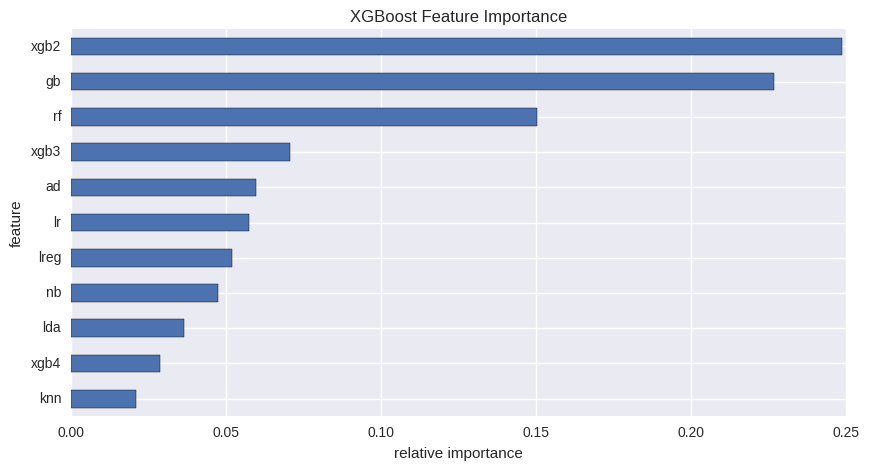

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

plt.figure()
df[-20:].plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(10, 5))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.show()

In [63]:
# Set up classifier
from sklearn.linear_model import LogisticRegression
cc = 1.0
model = LogisticRegression(C=cc)

In [69]:
X = train_meta.copy()
test = test_meta.copy()
print X.shape, test.shape

f_cats = [f for f in X.columns if "_cat" in f]

(595212, 11) (892816, 11)


In [70]:
y_valid_pred = 0*target
y_test_pred = 0

# Set up folds
from sklearn.model_selection import StratifiedKFold
K = 10
skf = StratifiedKFold(n_splits = K, random_state = 1, shuffle = True)
np.random.seed(0)

for i, (train_index, test_index) in enumerate(skf.split(X, target)):
    
    # Create data for this fold
    y_train, y_valid = target.iloc[train_index].copy(), target.iloc[test_index]
    X_train, X_valid = X.iloc[train_index,:].copy(), X.iloc[test_index,:].copy()
    X_test = test.copy()
    print( "\nFold ", i)
    
# #    Enocode data
#     for f in f_cats:
#         X_train[f + "_avg"], X_valid[f + "_avg"], X_test[f + "_avg"] = target_encode(
#                                                         trn_series=X_train[f],
#                                                         val_series=X_valid[f],
#                                                         tst_series=X_test[f],
#                                                         target=y_train,
#                                                         min_samples_leaf=200,
#                                                         smoothing=10,
#                                                         noise_level=0
#                                                         )

    eval_set=[(X_valid,y_valid)]
    fit_model = model.fit( X_train, y_train) 
#     , 
#                                eval_set=eval_set,
#                                eval_metric=gini_xgb,
#                                early_stopping_rounds=50,
#                                verbose=False
#                              )
#    print( "  Best N trees = ", model.best_ntree_limit )
#    print( "  Best gini = ", model.best_score )
        
    # Generate validation predictions for this fold
    pred = fit_model.predict_proba(X_valid)[:,1]
    print( "  Gini = ", eval_gini(y_valid, pred) )
    y_valid_pred.iloc[test_index] = pred
    
    # Accumulate test set predictions
    y_test_pred += fit_model.predict_proba(X_test)[:,1]
    
    del X_test, X_train, X_valid, y_train
    
y_test_pred /= K  # Average test set predictions

print( "\nGini for full training set:" )
print eval_gini(target, y_valid_pred)

('\nFold ', 0)
('  Gini = ', 0.27214636366382905)
('\nFold ', 1)
('  Gini = ', 0.28883348235779627)
('\nFold ', 2)
('  Gini = ', 0.28615430427859845)
('\nFold ', 3)
('  Gini = ', 0.28371952203322937)
('\nFold ', 4)
('  Gini = ', 0.2873186098308499)
('\nFold ', 5)
('  Gini = ', 0.27728778002157106)
('\nFold ', 6)
('  Gini = ', 0.2968527857474561)
('\nFold ', 7)
('  Gini = ', 0.2849901839672515)
('\nFold ', 8)
('  Gini = ', 0.29118833794974186)
('\nFold ', 9)
('  Gini = ', 0.2726991173929736)

Gini for full training set:
0.28411342804
